In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.minimum_norm import apply_inverse, make_inverse_operator, get_point_spread, make_inverse_resolution_matrix

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
limo_epochs = []
for subj in range(1,19):
    limo_epochs.append(load_data(subject=subj))

Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1055 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1052 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1050 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1118 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1108 matching ev

In [3]:
sbj2use = 0

phase_coh = limo_epochs[sbj2use].metadata['phase-coherence']
# get levels of phase coherence
levels = sorted(phase_coh.unique())
# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
epocheds = {label: limo_epochs[sbj2use][phase_coh == level]
           for level, label in zip(levels, labels)}

In [4]:
thr2use = '0.85'

epoched = epocheds[thr2use]
ch_names = epoched.info.ch_names[:128]


ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in ch_names])


standard_1020_montage = mne.channels.make_standard_montage('biosemi128')
standard_1020_ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in standard_1020_montage.ch_names]).tolist()


pos_ordered = dict()

for x in range(0, len(ch_names)):
    index=standard_1020_ch_names_lower.index(ch_names_lower[x])
    ch_names[x]=standard_1020_montage.ch_names[index]
    pos_ordered[ch_names[x]] = standard_1020_montage.dig[index]['r']

    
nasion = standard_1020_montage.dig[1]['r']
lpa = standard_1020_montage.dig[0]['r']
rpa = standard_1020_montage.dig[2]['r']

montage = mne.channels.make_dig_montage(pos_ordered, nasion, lpa, rpa, coord_frame='mri')


Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


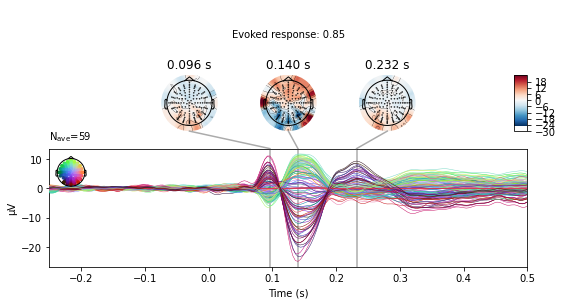

In [14]:
sfreq = 250
tmax = epoched.times[-1]

info = mne.create_info(ch_names=ch_names,sfreq=sfreq,ch_types='eeg')

epoched =mne.EpochsArray(epoched._data[:,:128,:],info,tmin=epoched.times[0]) 
epoched.set_montage(montage)
evoked = epoched.average()
evoked.set_eeg_reference('average', projection=True, verbose=False);
evoked.apply_baseline()
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.2)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25)

times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(times=times, title='Evoked response: ' + thr2use , ts_args=ts_args);

## Source Analysis

In [5]:
trans = 'MNI152_in_freesurfer-trans.fif'
bem = mne.read_bem_solution('MNI152_in_freesurfer-bem',verbose=False)
src = mne.read_source_spaces('MNI152_in_freesurfer-src.fif',verbose=False)

## View the source space

In [7]:
subjects_dir = r'/D:/Toronto/TMS_EEG/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir

src.plot(subjects_dir=subjects_dir)

Using pyvistaqt 3d backend.



Compute the covariance matrix

    The projection vectors do not apply to these channels.
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 113 dim * 14  max singular value)
    Estimated rank (eeg): 113
    EEG: rank 113 computed from 113 data channels with 0 projectors


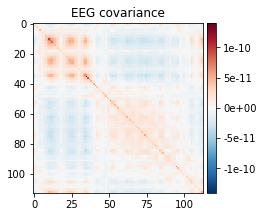

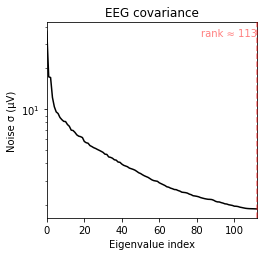

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [8]:
cov = mne.compute_covariance(epoched, method='auto', verbose=False)
cov.plot(epoched.info, proj=True)

Compute forward solution

In [9]:
fwd = mne.make_forward_solution(epoched.info, trans=trans,
                                src=src, bem=bem, meg=False, eeg=True,
                                mindist=5.0, n_jobs=2, verbose=False)

Compute the inverse solution

In [15]:
inv = make_inverse_operator(epoched.info, forward=fwd, noise_cov=cov, verbose=False)
#mne.minimum_norm.write_inverse_operator(os.path.join(data_dir + sub2use + '/TAY_' + sub2use + '_outcomes-inv.fif'), inv)
stc = apply_inverse(evoked, inv, method='dSPM', verbose=False) 

In [16]:
subjects_dir = r'/D:/Toronto/TMS_EEG/'
subject = 'MNI152_in_freesurfer'
os.environ['SUBJECTS_DIR'] = subjects_dir

stc.plot(hemi='both')

Using control points [ 3.62210204  4.65778137 11.94035974]


## Extract Labels

In [17]:
labels = mne.read_labels_from_annot(subject, parc='Schaefer2018_200Parcels_7Networks_order',
                                    subjects_dir=subjects_dir)
n_labels = len(labels)
label_colors = [label.color for label in labels]
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

Reading labels from parcellation...
   read 101 labels from D:Toronto\TMS_EEG\MNI152_in_freesurfer\label\lh.Schaefer2018_200Parcels_7Networks_order.annot
   read 101 labels from D:Toronto\TMS_EEG\MNI152_in_freesurfer\label\rh.Schaefer2018_200Parcels_7Networks_order.annot


In [18]:
label_stripped = []

for xx in range(1,201):
    label_stripped.append(labels[xx].name.replace('7Networks_',''))

    
label_ts = mne.extract_label_time_course(
    [stc], labels, src, mode='mean', allow_empty=True)[0]


Extracting time courses for 202 labels (mode: mean)


In [19]:
#indices = [i for i, s in enumerate(label_stripped) if 'Temp' in s]

indices_temp = [i for i, s in enumerate(label_stripped) if "lh" in s and "Temp" in s]

indices_pfc = [i for i, s in enumerate(label_stripped) if "lh" in s and "PFC" in s]

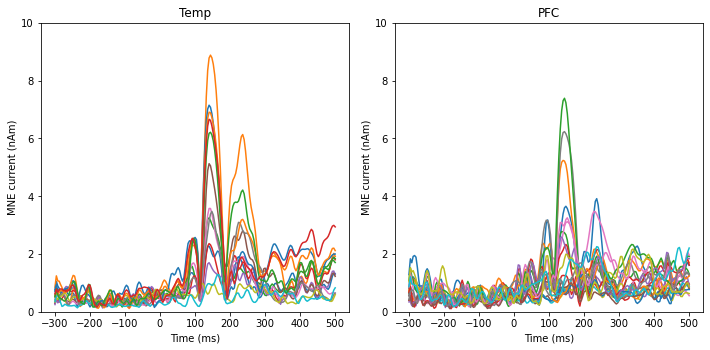

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

fig, axes = plt.subplots(1,2)

for pp in range(len(indices_temp)):
    axes[0].plot(1e3 * stc.times, label_ts[indices_temp[pp], :], label=label_stripped[indices_temp[pp]])
    axes[0].set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
    axes[0].set_title('Temp')
    axes[0].set_ylim([0, 10])


for pp in range(len(indices_pfc)):
    axes[1].plot(1e3 * stc.times, label_ts[indices_pfc[pp], :], label=label_stripped[indices_pfc[pp]])
    axes[1].set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
    axes[1].set_title('PFC')
    axes[1].set_ylim([0, 10])
    
#axes.legend()
mne.viz.tight_layout()

<AxesSubplot:>

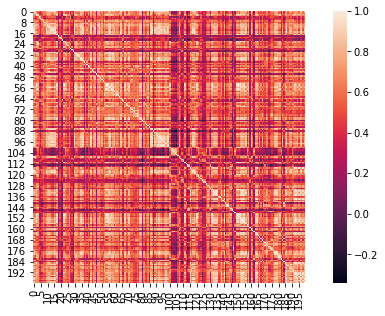

In [22]:
import seaborn as sns
sns.heatmap(np.corrcoef(label_ts[1:201,:]), square=True)